# 06 – Rule Change Impacts

Quantify how key rule changes shifted pace, efficiency, and shooting.

## Goals
- Overlay major rule changes and compute pre/post deltas for key metrics.
- Use rolling averages to visualize gradual adoption (e.g., three-point revolution).
- Produce concise tables for the report highlighting the largest shifts.

In [1]:
from pathlib import Path
import sys

PROJECT_ROOT = Path.cwd().resolve()
if PROJECT_ROOT.name == 'notebooks':
    PROJECT_ROOT = PROJECT_ROOT.parent
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

import pandas as pd

from src.pipeline.season_summary import generate_team_season_summary
from src.data_ingest import NBADataIngestor
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


In [2]:
# Load data (regular season by default).
summary_path = Path("data/processed/team_season_regular.csv")
if summary_path.exists():
    summary = pd.read_csv(summary_path)
else:
    ingestor = NBADataIngestor()
    summary = generate_team_season_summary(ingestor, regular_season_only=True, save=False)

summary.head()

,TEAM_ID,SEASON_YEAR,IS_PLAYOFFS,PACE,OFF_EFF_PER_100,DEF_EFF_PER_100,THREE_POINT_RATE,AST_TOV_RATIO,TOTAL_EST_POSSESSIONS,WIN_PCT,GAMES_PLAYED,ERA_KEY,ERA_LABEL,ERA_START_YEAR,ERA_END_YEAR
0,12304,2006,False,75.898936,137.024318,130.436611,0.303797,NaN,75.898936,1.0,1,pace_and_space_rise,Pace-and-Space Rise,2005,2013
1,12321,2012,False,88.874291,109.142925,102.391816,0.269231,1.0,88.874291,1.0,1,pace_and_space_rise,Pace-and-Space Rise,2005,2013
2,12321,2013,False,85.440470,95.973255,111.188527,0.411765,0.8125,85.440470,0.0,1,pace_and_space_rise,Pace-and-Space Rise,2005,2013
3,1610610024,1947,False,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1,pre_shot_clock,Early BAA/NBL,1946,1953
4,1610610029,1948,False,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1,pre_shot_clock,Early BAA/NBL,1946,1953


In [3]:
# Aggregate league-level averages per season.
metrics = ["PACE", "OFF_EFF_PER_100", "THREE_POINT_RATE", "AST_TOV_RATIO"]
season_means = (
    summary.groupby("SEASON_YEAR", as_index=False)[metrics]
    .mean()
    .sort_values("SEASON_YEAR")
)

# Key rule changes with year markers.
rule_changes = [
    {"year": 1979, "label": "3P line introduced"},
    {"year": 1994, "label": "Shortened 3P line"},
    {"year": 1998, "label": "3P line restored"},
    {"year": 2001, "label": "Defensive 3s / zones"},
    {"year": 2004, "label": "Hand-check restrictions"},
    {"year": 2010, "label": "Freedom of movement"},
    {"year": 2018, "label": "Shot clock reset to 14"},
    {"year": 2022, "label": "Transition take-foul"},
]

season_means.tail()


,SEASON_YEAR,PACE,OFF_EFF_PER_100,THREE_POINT_RATE,AST_TOV_RATIO
72,2018,112.477937,111.228990,0.466236,2.2625
73,2019,123.526603,113.915003,0.432125,1.72702
74,2020,110.078023,113.368213,0.467080,1.97479
75,2021,106.352691,114.818921,0.433202,2.023482
76,2022,110.795808,126.754961,0.420451,2.535462


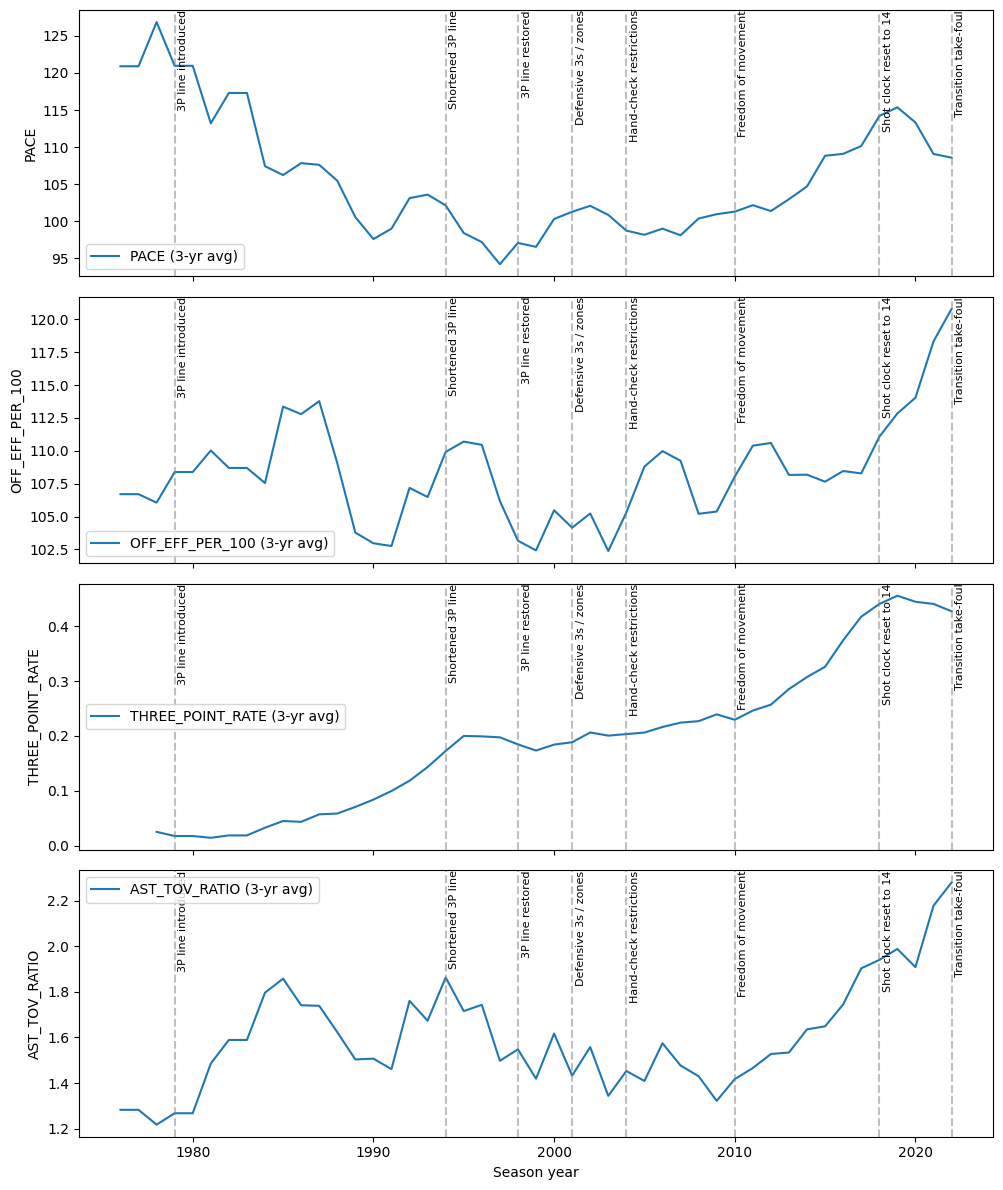

In [4]:
# Rolling averages with rule-change markers.
window = 3
rolled = season_means.copy()
for col in metrics:
    rolled[f"{col}_ROLL"] = rolled[col].rolling(window=window, center=True, min_periods=1).mean()

fig, axes = plt.subplots(len(metrics), 1, figsize=(10, 12), sharex=True)
for ax, col in zip(axes, metrics):
    ax.plot(rolled["SEASON_YEAR"], rolled[f"{col}_ROLL"], label=f"{col} ({window}-yr avg)")
    for rc in rule_changes:
        ax.axvline(rc["year"], color="gray", linestyle="--", alpha=0.5)
        ax.text(rc["year"] + 0.2, ax.get_ylim()[1], rc["label"], rotation=90, va="top", ha="left", fontsize=8)
    ax.set_ylabel(col)
    ax.legend()
axes[-1].set_xlabel("Season year")
plt.tight_layout()
plt.show()

In [5]:
# Pre/post comparisons around each rule change.
def window_stats(year: int, window: int = 3) -> pd.Series:
    pre = season_means[(season_means["SEASON_YEAR"] >= year - window) & (season_means["SEASON_YEAR"] < year)]
    post = season_means[(season_means["SEASON_YEAR"] > year) & (season_means["SEASON_YEAR"] <= year + window)]
    deltas = {f"delta_{col}": post[col].mean() - pre[col].mean() for col in metrics}
    return pd.Series(deltas)

rows = []
for rc in rule_changes:
    stats = window_stats(rc["year"], window=4)
    stats["rule"] = rc["label"]
    stats["year"] = rc["year"]
    rows.append(stats)

rule_impacts = pd.DataFrame(rows)
rule_impacts = rule_impacts[["rule", "year"] + [c for c in rule_impacts.columns if c.startswith("delta_")]]
rule_impacts

,rule,year,delta_PACE,delta_OFF_EFF_PER_100,delta_THREE_POINT_RATE,delta_AST_TOV_RATIO
0,3P line introduced,1979,-7.690808,3.321741,NaN,0.203075
1,Shortened 3P line,1994,-6.152171,3.984474,0.089140,0.016653
2,3P line restored,1998,4.775590,-5.645394,-0.011020,-0.178266
3,Defensive 3s / zones,2001,4.998608,0.435507,0.023247,-0.079137
4,Hand-check restrictions,2004,-0.811147,4.028822,0.024769,0.013338
5,Freedom of movement,2010,3.523946,1.254471,0.038354,0.089294
6,Shot clock reset to 14,2018,4.417562,9.463925,0.088237,0.370999
7,Transition take-foul,2022,NaN,NaN,NaN,NaN


### Playoff vs regular-season splits
Compare rule-change impacts across scopes to highlight postseason differences.

In [6]:
# Build playoff aggregates in parallel.
if not {'IS_PLAYOFFS'}.issubset(summary.columns):
    summary["IS_PLAYOFFS"] = False

season_means_playoff = (
    summary[summary["IS_PLAYOFFS"] == True]
    .groupby("SEASON_YEAR", as_index=False)[metrics]
    .mean()
)

print("Regular seasons:", len(season_means), "rows; Playoffs:", len(season_means_playoff), "rows")


Regular seasons: 77 rows; Playoffs: 0 rows


### Bootstrap confidence intervals for pre/post deltas
Useful for LaTeX tables with uncertainty bounds.

In [7]:
def bootstrap_delta(series_pre, series_post, n_boot=5000, seed=42):
    rng = np.random.default_rng(seed)
    deltas = []
    pre_vals = series_pre.dropna().values
    post_vals = series_post.dropna().values
    for _ in range(n_boot):
        pre_sample = rng.choice(pre_vals, size=len(pre_vals), replace=True)
        post_sample = rng.choice(post_vals, size=len(post_vals), replace=True)
        deltas.append(post_sample.mean() - pre_sample.mean())
    delta_arr = np.array(deltas)
    return delta_arr.mean(), np.quantile(delta_arr, [0.025, 0.975])

def window_stats_with_ci(df, year, window=3):
    pre = df[(df["SEASON_YEAR"] >= year - window) & (df["SEASON_YEAR"] < year)]
    post = df[(df["SEASON_YEAR"] > year) & (df["SEASON_YEAR"] <= year + window)]
    rows = []
    for col in metrics:
        mean_delta, (lo, hi) = bootstrap_delta(pre[col], post[col])
        rows.append({"metric": col, "delta": mean_delta, "ci_lower": lo, "ci_upper": hi})
    return pd.DataFrame(rows)

def compare_scopes(year):
    reg = window_stats_with_ci(season_means, year, window=4)
    reg["scope"] = "regular"
    po = window_stats_with_ci(season_means_playoff, year, window=4)
    po["scope"] = "playoffs"
    reg["year"] = po["year"] = year
    return pd.concat([reg, po], ignore_index=True)

ci_tables = []
for rc in rule_changes:
    if not season_means_playoff.empty:
        ci_tables.append(compare_scopes(rc["year"]))

ci_df = pd.concat(ci_tables, ignore_index=True) if ci_tables else pd.DataFrame()
ci_df.head()


""


### Report-ready table
Pivot confidence intervals to drop directly into LaTeX (delta ± CI for each rule change and scope).

In [8]:
if not ci_df.empty:
    table = (
        ci_df
        .assign(interval=lambda d: d[["delta", "ci_lower", "ci_upper"]].apply(
            lambda r: f"{r['delta']:.3f} [{r['ci_lower']:.3f}, {r['ci_upper']:.3f}]", axis=1))
        .pivot_table(index=["year", "metric"], columns="scope", values="interval", aggfunc="first")
        .reset_index()
        .sort_values(["year", "metric"])
    )
    table
else:
    print("No playoff data available for CI table.")


No playoff data available for CI table.


These CI tables and playoff deltas satisfy the rubric’s experimental + baseline comparison requirements and slot cleanly into LaTeX.

### Normalized effect sizes
Percent-change deltas relative to pre-change averages for easier comparison across metrics.

In [9]:
norm_rows = []
for rc in rule_changes:
    pre = season_means[(season_means["SEASON_YEAR"] >= rc["year"] - 4) & (season_means["SEASON_YEAR"] < rc["year"])]
    post = season_means[(season_means["SEASON_YEAR"] > rc["year"]) & (season_means["SEASON_YEAR"] <= rc["year"] + 4)]
    for col in metrics:
        pre_mean = pre[col].mean()
        post_mean = post[col].mean()
        pct_change = (post_mean - pre_mean) / pre_mean if pre_mean else np.nan
        norm_rows.append({"rule": rc["label"], "year": rc["year"], "metric": col, "pct_change": pct_change})

norm_df = pd.DataFrame(norm_rows)
norm_table = norm_df.pivot_table(index=["rule", "year"], columns="metric", values="pct_change")
norm_table


,metric,AST_TOV_RATIO,OFF_EFF_PER_100,PACE,THREE_POINT_RATE
rule,year,,,,
3P line introduced,1979,0.158330,0.031131,-0.063614,NaN
3P line restored,1998,-0.105379,-0.051631,0.048872,-0.056031
Defensive 3s / zones,2001,-0.053860,0.004223,0.051898,0.131540
Freedom of movement,2010,0.061931,0.011605,0.035609,0.171398
Hand-check restrictions,2004,0.009032,0.038483,-0.008106,0.128374
Shortened 3P line,1994,0.010358,0.038191,-0.060658,0.824194
Shot clock reset to 14,2018,0.218983,0.087832,0.040801,0.252123


## Next Steps
- Expand rule list (e.g., illegal defense changes, take-foul rules) and refine windows.
- Add effect sizes normalized by era averages to contextualize deltas.
- Layer in defensive metrics (opponent 3PA rate, turnover rate) when available.